In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import os
import networkx as nx

In [2]:
import pandas as pd

#Read discussion network data from a csv file
dnet_df = pd.read_csv('discussion_network_with_affiliations.csv')
#Display the first 5 rows of the dataframe
dnet_df.head()

,consumer,contributor,consumption,contributor_affiliation,consumer_affiliation
0,mitsudome-r,maxime-clem,1,tier4,tier4
1,mitsudome-r,xczhanjun,1,baidu usa,tier4
2,mitsudome-r,xmfcx,7,leodrive,tier4
3,mitsudome-r,meliketanrikulu,1,leodrive,tier4
4,mitsudome-r,kminoda,1,tier4,tier4


In [3]:
dnet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   consumer                 1087 non-null   object
 1   contributor              1087 non-null   object
 2   consumption              1087 non-null   int64 
 3   contributor_affiliation  981 non-null    object
 4   consumer_affiliation     707 non-null    object
dtypes: int64(1), object(4)
memory usage: 42.6+ KB


In [4]:
#Aggregate the data by contributor_affiliation and consumer_affiliation, sum teh values of consumption, keep the contributor_affiliation and consumer_affiliation columns
dnet_grouped = dnet_df.groupby(['consumer', 'contributor'])['consumption'].sum().reset_index()
#Display the first 5 rows of the dataframe
dnet_grouped.head()

,consumer,contributor,consumption
0,08beeqtufail-sudo,TakaHoribe,1
1,AElkenawy,Levinskis,1
2,AElkenawy,wbq0206,1
3,AElkenawy,zulfaqar-azmi-t4,1
4,AhmadAmine998,TakaHoribe,1


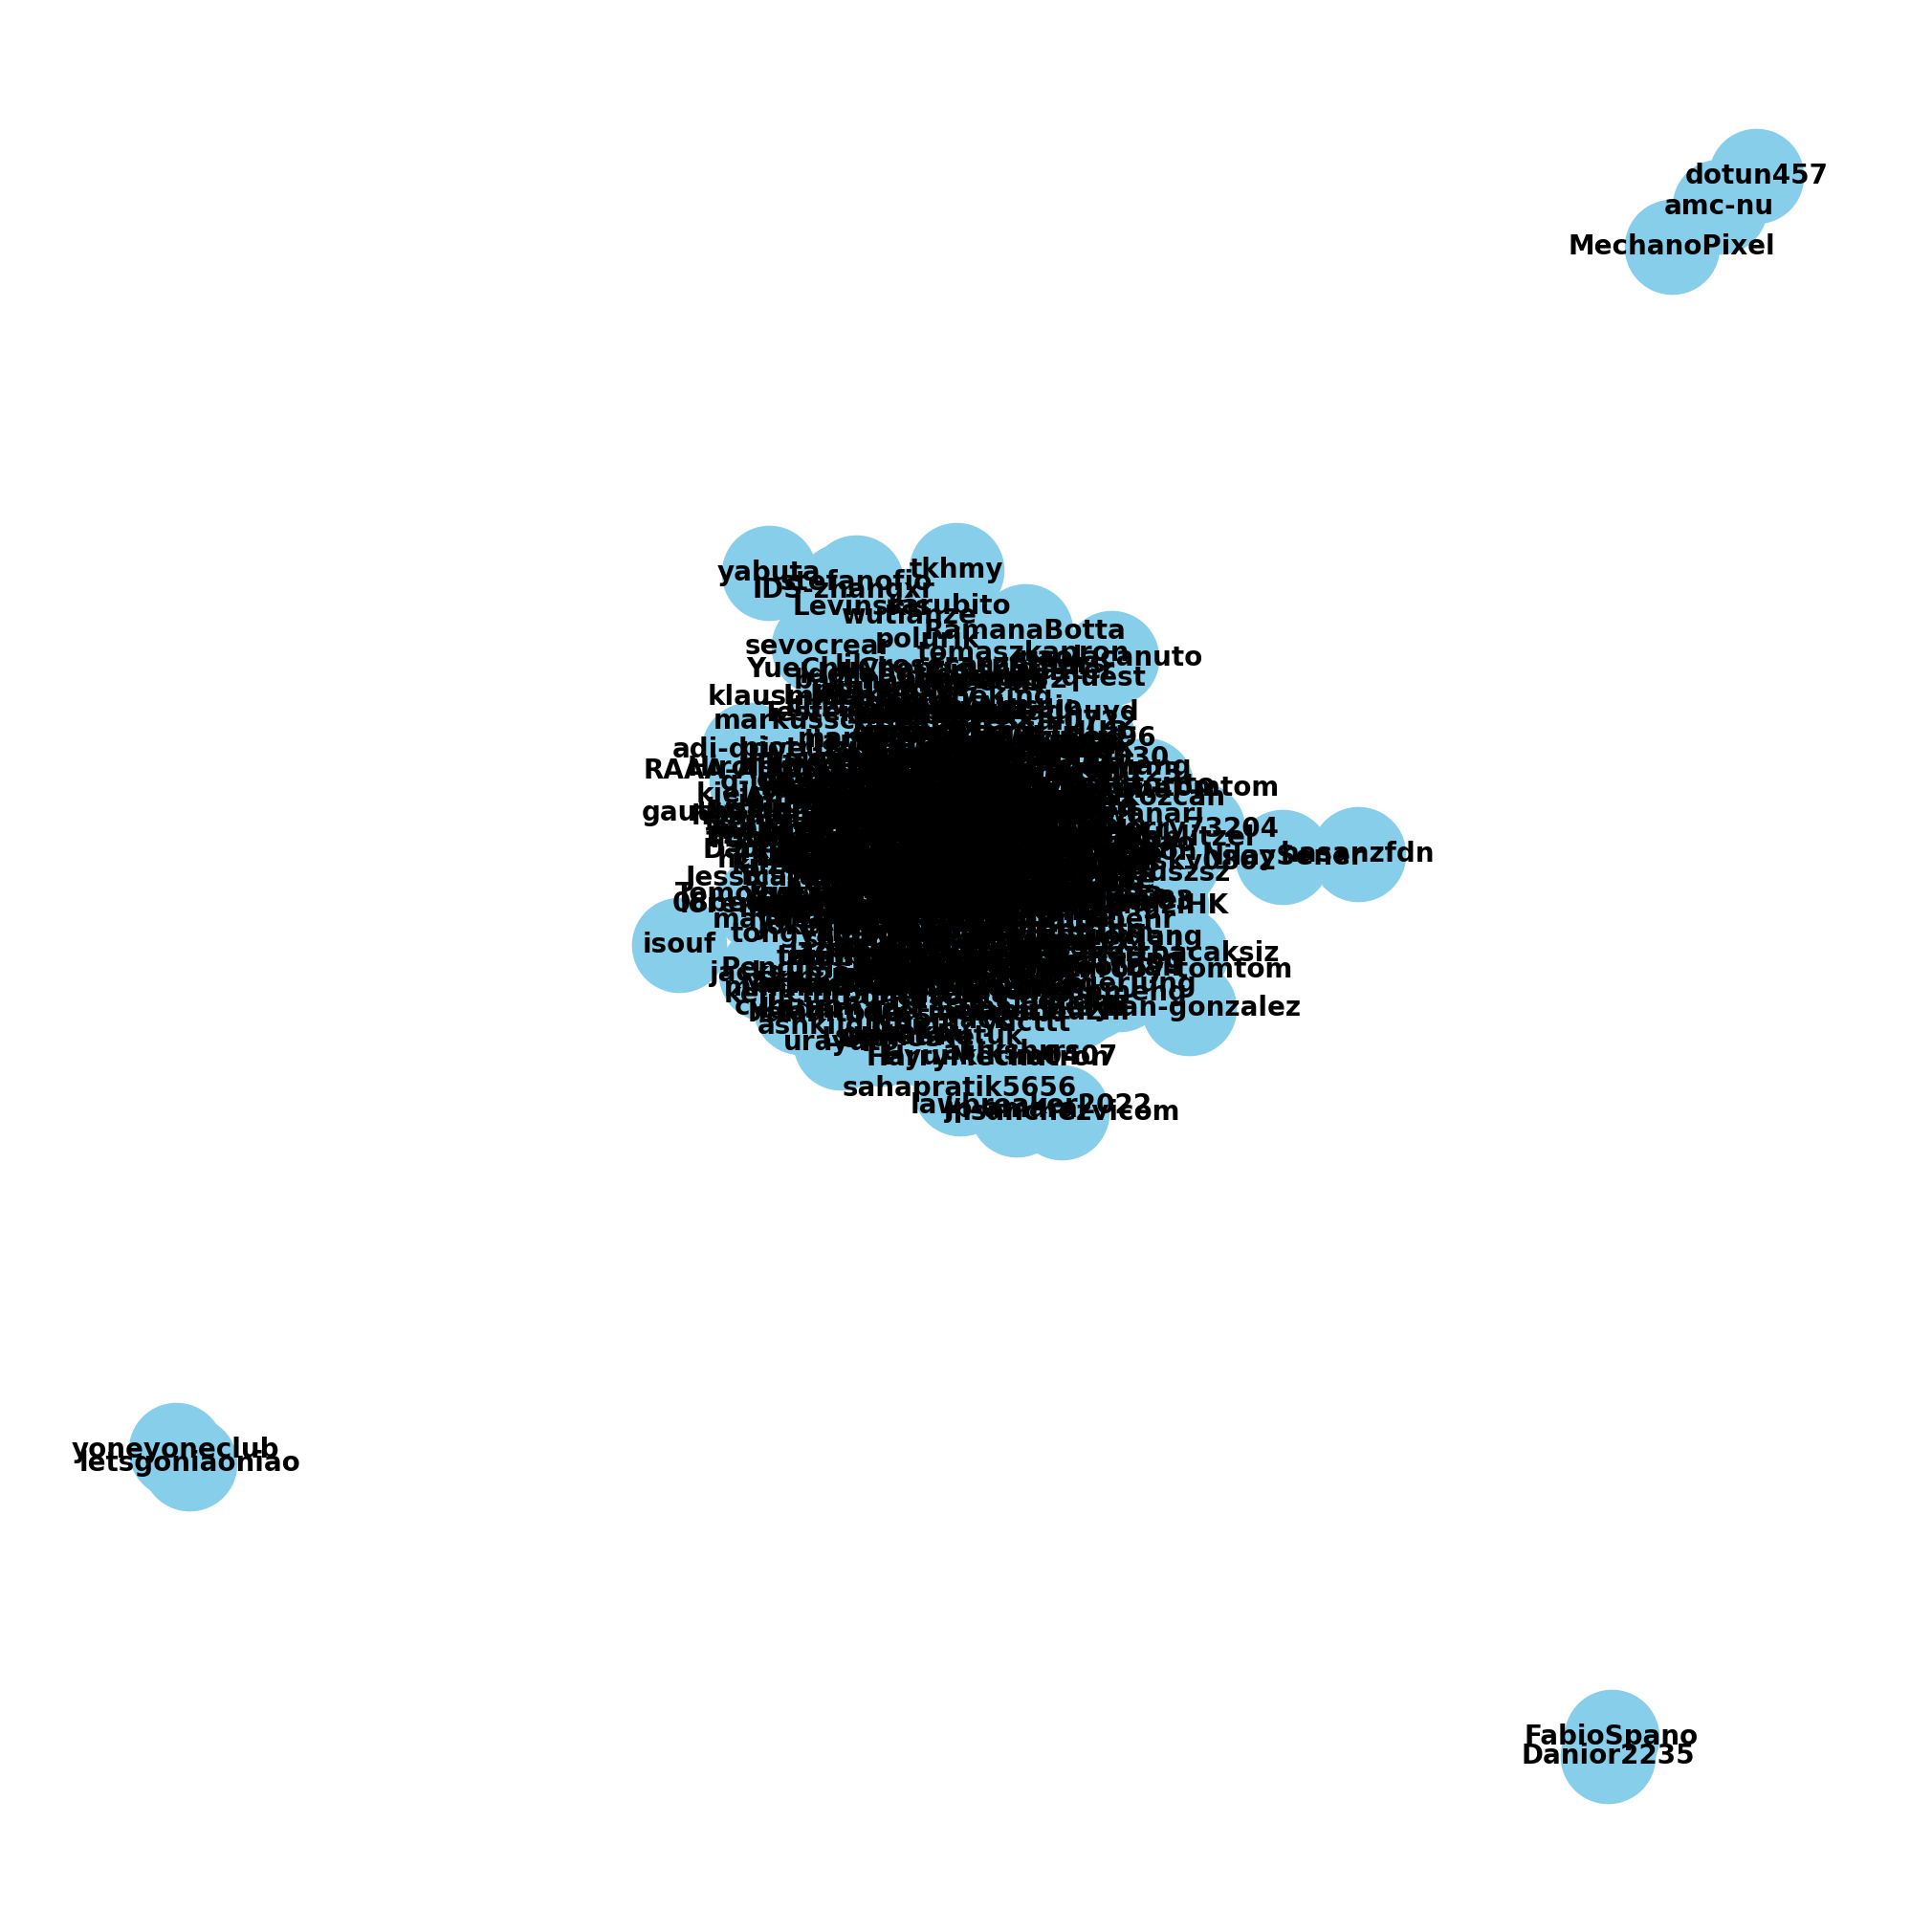

In [5]:
#Draw a network among the affiliations based on the consumption of the discussions
G = nx.from_pandas_edgelist(dnet_grouped, 'consumer', 'contributor', 'consumption')
plt.figure(figsize=(20, 20))
nx.draw(G, with_labels=True, node_size=5000, node_color='skyblue', font_size=20, font_weight='bold')
plt.show()

In [6]:
!pip install pyvis

In [7]:
import pandas as pd
from pyvis.network import Network

# Read discussion network data from a csv file
dnet_df = pd.read_csv('discussion_network_with_affiliations.csv')

# Aggregate the data by contributor_affiliation and consumer_affiliation, sum the values of consumption
dnet_grouped = dnet_df.groupby(['consumer', 'contributor'])['consumption'].sum().reset_index()

# Sort the DataFrame by consumption (highest to lowest)
dnet_grouped_sorted = dnet_grouped.sort_values(by='consumption', ascending=False)

# Create a pyvis network with a white background
net = Network(height="750px", width="100%", bgcolor="white", font_color="black", directed=True)

# Create an empty dictionary to store added nodes
added_nodes = {}

# Define the minimum weight threshold for displaying edges
min_weight_threshold = 2

# Create a dictionary to store the count of rows for each pair of interchangeable affiliations
interchangeable_counts = {}

# Count the occurrences of each pair of interchangeable affiliations
for _, row in dnet_grouped.iterrows():
    contributor_affiliation = row['contributor']
    consumer_affiliation = row['consumer']
    if contributor_affiliation > consumer_affiliation:
        pair = (consumer_affiliation, contributor_affiliation)
    else:
        pair = (contributor_affiliation, consumer_affiliation)
    interchangeable_counts[pair] = interchangeable_counts.get(pair, 0) + 1

# Add nodes for each unique affiliation (handling potential missing values)
for affiliation in pd.concat([dnet_grouped_sorted['contributor'], dnet_grouped_sorted['consumer']]).unique():
    if not pd.isna(affiliation):
        net.add_node(affiliation, label=affiliation, size=20, color='lightblue')
        added_nodes[affiliation] = True

# Add edges to the network with the aggregated consumption values and adjusted width
for index, row in dnet_grouped_sorted.iterrows():
    contributor_affiliation = row['contributor']
    consumer_affiliation = row['consumer']
    consumption = row['consumption']

    # Add edge only if contributor and consumer affiliations are not NaN and weight meets threshold
    if not pd.isna(consumer_affiliation) and not pd.isna(contributor_affiliation) and consumption >= min_weight_threshold:
        # Ensure we add edges in both directions for interchangeable affiliations
        edge_key = (contributor_affiliation, consumer_affiliation)
        if interchangeable_counts.get(edge_key, 0) > 1:
            # Add edge between affiliations in both directions if not added already
            if edge_key not in added_nodes:
                net.add_edge(contributor_affiliation, consumer_affiliation, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[edge_key] = True
            if (consumer_affiliation, contributor_affiliation) not in added_nodes:
                net.add_edge(consumer_affiliation, contributor_affiliation, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[(consumer_affiliation, contributor_affiliation)] = True
        else:
            # Add only one edge if the affiliations are not interchangeable or there's only one occurrence
            if edge_key not in added_nodes:
                net.add_edge(contributor_affiliation, consumer_affiliation, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[edge_key] = True

# Set the layout algorithm to force-directed
net.barnes_hut(gravity=-8000, central_gravity=0.3, spring_length=200)

# Save the network to an HTML file
net.save_graph("discussion_user_network_directed.html")

In [8]:
discussion_df = pd.read_csv('updated_user_details.csv')
discussion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        567 non-null    int64  
 1   user_id                           567 non-null    object 
 2   skills                            147 non-null    object 
 3   email                             324 non-null    object 
 4   location                          133 non-null    object 
 5   affiliation                       368 non-null    object 
 6   name                              400 non-null    object 
 7   discussion_thread                 352 non-null    float64
 8   discussion_thread_internal        352 non-null    float64
 9   discussion_thread_external        352 non-null    float64
 10  discussion_contribution           352 non-null    float64
 11  discussion_contribution_internal  352 non-null    float64
 12  discussi

In [9]:
# Specify columns to remove
columns_to_remove = ['Unnamed: 0']

# Drop the specified columns
discussion_df = discussion_df.drop(columns=columns_to_remove)

discussion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   user_id                           567 non-null    object 
 1   skills                            147 non-null    object 
 2   email                             324 non-null    object 
 3   location                          133 non-null    object 
 4   affiliation                       368 non-null    object 
 5   name                              400 non-null    object 
 6   discussion_thread                 352 non-null    float64
 7   discussion_thread_internal        352 non-null    float64
 8   discussion_thread_external        352 non-null    float64
 9   discussion_contribution           352 non-null    float64
 10  discussion_contribution_internal  352 non-null    float64
 11  discussion_contribution_external  352 non-null    float64
 12  discussi

In [10]:
import pandas as pd

# Assuming discussion_df is already defined and contains the data as described
# Calculate the average of 'discussion_contribution' and 'discussion_thread' columns
avg_discussion_contribution = discussion_df['discussion_contribution'].mean()
avg_discussion_thread = discussion_df['discussion_thread'].mean()

# Define the formula for 'discussions_node_size'
discussion_df['discussion_node_size'] = (
    (discussion_df['discussion_contribution'] / avg_discussion_contribution) +
    (discussion_df['discussion_thread'] / avg_discussion_thread)
)

# Display the updated DataFrame info to check the new column
print(discussion_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   user_id                           567 non-null    object 
 1   skills                            147 non-null    object 
 2   email                             324 non-null    object 
 3   location                          133 non-null    object 
 4   affiliation                       368 non-null    object 
 5   name                              400 non-null    object 
 6   discussion_thread                 352 non-null    float64
 7   discussion_thread_internal        352 non-null    float64
 8   discussion_thread_external        352 non-null    float64
 9   discussion_contribution           352 non-null    float64
 10  discussion_contribution_internal  352 non-null    float64
 11  discussion_contribution_external  352 non-null    float64
 12  discussi

In [11]:
import pandas as pd
from pyvis.network import Network
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Read discussion network data from a csv file
dnet_df = pd.read_csv('discussion_network_with_affiliations.csv')

# # Read the discussion_df with user_id and discussions_node_size
# discussion_df = pd.read_csv('discussion_df.csv')

# Aggregate the data by contributor_affiliation and consumer_affiliation, sum the values of consumption
dnet_grouped = dnet_df.groupby(['consumer', 'contributor'])['consumption'].sum().reset_index()

# Sort the DataFrame by consumption (highest to lowest)
dnet_grouped_sorted = dnet_grouped.sort_values(by='consumption', ascending=False)

# Create a pyvis network with a white background
net = Network(height="750px", width="100%", bgcolor="white", font_color="black", directed=True)

# Create an empty dictionary to store added nodes
added_nodes = {}

# Define the minimum weight threshold for displaying edges
min_weight_threshold = 3
# Create a dictionary to store the count of rows for each pair of interchangeable affiliations
interchangeable_counts = {}

# Count the occurrences of each pair of interchangeable affiliations
for _, row in dnet_grouped.iterrows():
    contributor_affiliation = row['contributor']
    consumer_affiliation = row['consumer']
    if contributor_affiliation > consumer_affiliation:
        pair = (consumer_affiliation, contributor_affiliation)
    else:
        pair = (contributor_affiliation, consumer_affiliation)
    interchangeable_counts[pair] = interchangeable_counts.get(pair, 0) + 1

# Generate a color map for the affiliations
unique_affiliations = pd.concat([dnet_df['contributor_affiliation'], dnet_df['consumer_affiliation']]).unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_affiliations)))
affiliation_color_map = {affiliation: mcolors.to_hex(color) for affiliation, color in zip(unique_affiliations, colors)}

# Add nodes for each unique affiliation (handling potential missing values)
for affiliation in pd.concat([dnet_grouped_sorted['contributor'], dnet_grouped_sorted['consumer']]).unique():
    if not pd.isna(affiliation):
        # Set default size and color
        node_size = 20
        node_color = 'lightblue'

        # Check if the affiliation matches any user_id in discussion_df
        matching_user = discussion_df[discussion_df['user_id'] == affiliation]
        if not matching_user.empty:
            node_size = matching_user['discussion_node_size'].values[0]
            user_affiliation = matching_user['affiliation'].values[0]
            node_color = affiliation_color_map.get(user_affiliation, 'lightblue')

        net.add_node(affiliation, label=affiliation, size=node_size, color=node_color)
        added_nodes[affiliation] = True

# Add edges to the network with the aggregated consumption values and adjusted width
for index, row in dnet_grouped_sorted.iterrows():
    contributor_affiliation = row['contributor']
    consumer_affiliation = row['consumer']
    consumption = row['consumption']

    # Add edge only if contributor and consumer affiliations are not NaN and weight meets threshold
    if not pd.isna(consumer_affiliation) and not pd.isna(contributor_affiliation) and consumption >= min_weight_threshold:
        # Ensure we add edges in both directions for interchangeable affiliations
        edge_key = (contributor_affiliation, consumer_affiliation)
        if interchangeable_counts.get(edge_key, 0) > 1:
            # Add edge between affiliations in both directions if not added already
            if edge_key not in added_nodes:
                net.add_edge(contributor_affiliation, consumer_affiliation, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[edge_key] = True
            if (consumer_affiliation, contributor_affiliation) not in added_nodes:
                net.add_edge(consumer_affiliation, contributor_affiliation, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[(consumer_affiliation, contributor_affiliation)] = True
        else:
            # Add only one edge if the affiliations are not interchangeable or there's only one occurrence
            if edge_key not in added_nodes:
                net.add_edge(contributor_affiliation, consumer_affiliation, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[edge_key] = True

# Set the layout algorithm to force-directed
net.barnes_hut(gravity=-8000, central_gravity=0.3, spring_length=200)

# Save the network to an HTML file
net_html = net.generate_html()

# Create the HTML string for the affiliation colors
affiliation_colors_html = "<h2>Affiliation Colors</h2><table border='1'><tr><th>Affiliation</th><th>Color</th></tr>"
for affiliation, color in affiliation_color_map.items():
    affiliation_colors_html += f"<tr><td>{affiliation}</td><td style='background-color:{color}; color:{color};'>{color}</td></tr>"
affiliation_colors_html += "</table>"

# Combine the network HTML with the affiliation colors HTML
full_html = net_html.replace("</body>", f"{affiliation_colors_html}</body>")

# Save the combined HTML to a file
with open("discussion_user_network_directed.html", "w") as f:
    f.write(full_html)